In [30]:
# %% [markdown]
# # K–Means Clustering Testing
# This notebook loads a pre-trained K–Means model and a scaler, then tests the model on a specified fraction of a new dataset. 
# It computes evaluation metrics (such as silhouette score and—if ground truth is available—a confusion matrix) and saves the outputs.

# %% [code]
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, classification_report, 
                             silhouette_score)
from sklearn.model_selection import train_test_split

In [31]:
# %% [markdown]
# ## Parameter Definition
# Adjust the following parameters as needed.

# Path to the dataset (CSV file)
dataset_path = r"C:\Users\mrroo\Desktop\RP3\datasets\2018.csv"  # UPDATE AS NEEDED

# Fraction of the dataset to use for testing (e.g., 1.0 for 100%, 0.1 for 10%)
sample_fraction = 0.03

# Run name and other identifiers for output folders
run_name = "kmeans_test_run_full"  # Change as desired
year = "2018"
model_name = "KMeans"

# Define the output folder for this run
output_folder = os.path.join("outputs", year, model_name, run_name)
os.makedirs(output_folder, exist_ok=True)
print("Output folder created:", output_folder)

Output folder created: outputs\2018\KMeans\kmeans_test_run_full


In [32]:
# %% [markdown]
# ## Load Saved Model and Scaler
# Update the following paths to point to your saved artifacts.
kmeans_model_path = r"C:\Users\mrroo\Desktop\RP3\Imp\Outputs\2018\k-means\run1-20%\kmeans_models\k_9\kmeans_model_9.pkl"  # UPDATE PATH
scaler_path = r"C:\Users\mrroo\Desktop\RP3\Imp\Outputs\2018\k-means\run1-20%\scaler.pkl"  # UPDATE PATH
pca_model_path = r"C:\Users\mrroo\Desktop\RP3\Imp\Outputs\2018\k-means\run1-20%\pca_clustering_model.pkl"   # Update as needed

# Load the saved K–Means model and scaler
kmeans_model = joblib.load(kmeans_model_path)
pca_clustering = joblib.load(pca_model_path)
scaler_loaded = joblib.load(scaler_path)

In [33]:
# %% [markdown]
# ## Data Loading & Preprocessing
# Load the dataset, print basic information, and sample a fraction for testing.
# (If your dataset has a 'label' column, it will be used for evaluation.)

# %% [code]
data = pd.read_csv(dataset_path)
print("Original dataset shape:", data.shape)
print("First few rows:")
print(data.head())
print("\nDataset info:")
print(data.info())

# Print class distribution if available
if 'label' in data.columns:
    print("\nClass distribution:")
    print(data['label'].value_counts())

# Sample the dataset if desired
data = data.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
print(f"Dataset shape after sampling {sample_fraction*100:.0f}%:", data.shape)

# Remove any misread header rows (if 'label' equals 'label')
data = data[data['label'] != 'label']

Original dataset shape: (4339650, 26)
First few rows:
    timestamp  Dst Port  protocol  Flow Duration  Flow Duration_rolling_mean  \
0  1518745716   55250.0       6.0       958807.0                   1815614.1   
1  1519099848     443.0       6.0      6081730.0                   2284039.7   
2  1519179901   52453.0       6.0         1428.0                      6703.5   
3  1518659728    3389.0       6.0      2169521.0                   9191415.4   
4  1519116456   49913.0       6.0           97.0                  24709922.5   

   Flow Duration_rolling_std  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0               1.965582e+06           5.0           3.0            935.0   
1               2.888929e+06          10.0          12.0            646.0   
2               8.135168e+03           5.0           2.0            935.0   
3               2.752269e+07           8.0           7.0           1132.0   
4               4.818137e+07           3.0           1.0             31.0   

  

In [34]:
# %% [markdown]
# ### Dynamically Encode Labels (if ground truth is available)
# This step is optional for unsupervised clustering but useful if you want to evaluate the clustering quality against true labels.
# %% [code]
if 'label' in data.columns:
    data['label'], uniques = pd.factorize(data['label'])
    label_names = {i: label for i, label in enumerate(uniques)}
    print("\nEncoded labels mapping:")
    print(label_names)
else:
    print("No 'label' column found; skipping label encoding.")

# %% [markdown]
# ### Feature Selection
# Select all columns except those that should not be used as features (e.g., 'timestamp', 'label').
# %% [code]
# Option 1: Manually define features (if desired)
manual_features = ['pkts_ratio', 'Tot Bwd Pkts', 'Dst Port', 'Fwd Pkt Len Max',
                   'SYN Flag Cnt', 'byte_per_duration', 'Bwd Pkt Len Min', 'protocol',
                   'Fwd Pkt Len Mean', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Flow Duration',
                   'Flow Duration_rolling_std', 'Flow Duration_rolling_mean', 'Bwd Pkt Len Max',
                   'Fwd IAT Tot', 'TotLen Fwd Pkts', 'Subflow Fwd Byts', 'Fwd IAT Max',
                   'Tot Fwd Pkts', 'Fwd IAT Min', 'Fwd IAT Mean', 'Fwd Pkt Len Std',
                   'entropy_pkt_len']

try:
    selected_features = manual_features
except NameError:
    selected_features = [col for col in data.columns if col.lower() not in ['timestamp', 'label']]

print("\nSelected features:")
print(selected_features)

X = data[selected_features]
if 'label' in data.columns:
    y = data['label']

# Drop rows with missing feature values
num_rows_before = X.shape[0]
X = X.dropna()
num_rows_after = X.shape[0]
print("Number of rows dropped due to missing values:", num_rows_before - num_rows_after)


Encoded labels mapping:
{0: 'Benign', 1: 'DoS attacks-Hulk', 2: 'DDoS attacks-LOIC-HTTP', 3: 'DDOS attack-HOIC', 4: 'DoS attacks-SlowHTTPTest', 5: 'DoS attacks-GoldenEye', 6: 'DoS attacks-Slowloris', 7: 'DDOS attack-LOIC-UDP'}

Selected features:
['pkts_ratio', 'Tot Bwd Pkts', 'Dst Port', 'Fwd Pkt Len Max', 'SYN Flag Cnt', 'byte_per_duration', 'Bwd Pkt Len Min', 'protocol', 'Fwd Pkt Len Mean', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Flow Duration', 'Flow Duration_rolling_std', 'Flow Duration_rolling_mean', 'Bwd Pkt Len Max', 'Fwd IAT Tot', 'TotLen Fwd Pkts', 'Subflow Fwd Byts', 'Fwd IAT Max', 'Tot Fwd Pkts', 'Fwd IAT Min', 'Fwd IAT Mean', 'Fwd Pkt Len Std', 'entropy_pkt_len']
Number of rows dropped due to missing values: 0


In [35]:
# %% [markdown]
# ### Standardize Features
# IMPORTANT: Ensure the order of features matches what was used during training.
# %% [code]
if hasattr(scaler_loaded, "feature_names_in_"):
    correct_feature_order = list(scaler_loaded.feature_names_in_)
    print("Feature order from training:", correct_feature_order)
    X = X[correct_feature_order]
else:
    X = X[selected_features]

X_scaled = scaler_loaded.transform(X)
print("Scaled features shape:", X_scaled.shape)

Feature order from training: ['pkts_ratio', 'Tot Bwd Pkts', 'Dst Port', 'Fwd Pkt Len Max', 'SYN Flag Cnt', 'byte_per_duration', 'Bwd Pkt Len Min', 'protocol', 'Fwd Pkt Len Mean', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Flow Duration', 'Flow Duration_rolling_std', 'Flow Duration_rolling_mean', 'Bwd Pkt Len Max', 'Fwd IAT Tot', 'TotLen Fwd Pkts', 'Subflow Fwd Byts', 'Fwd IAT Max', 'Tot Fwd Pkts', 'Fwd IAT Min', 'Fwd IAT Mean', 'Fwd Pkt Len Std', 'entropy_pkt_len']
Scaled features shape: (130190, 24)


Transformed test features shape: (130190, 8)
Predicted cluster labels shape: (130190,)
Silhouette Score: 0.5928878336877542

Confusion Matrix:
[[ 6493 15924  8125 27177     0 10452    82    28  4324]
 [   46   710 13051     0     0     0     0     0     0]
 [    0     0 11837     4    27     0  5274     0     0]
 [    0  5000 15465     0     0     0     0     0     0]
 [    0     0  4174     0     0     0     0     0     0]
 [    6   999   329     0     0     0   208     0     0]
 [  190     3    71     2     0     0   106     0    33]
 [    1     0     0     2    47     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.09      0.16     72605
           1       0.03      0.05      0.04     13807
           2       0.22      0.69      0.34     17142
           3       0.00      0.00      0.00     20465
           4       0.00      0.00      0.00     

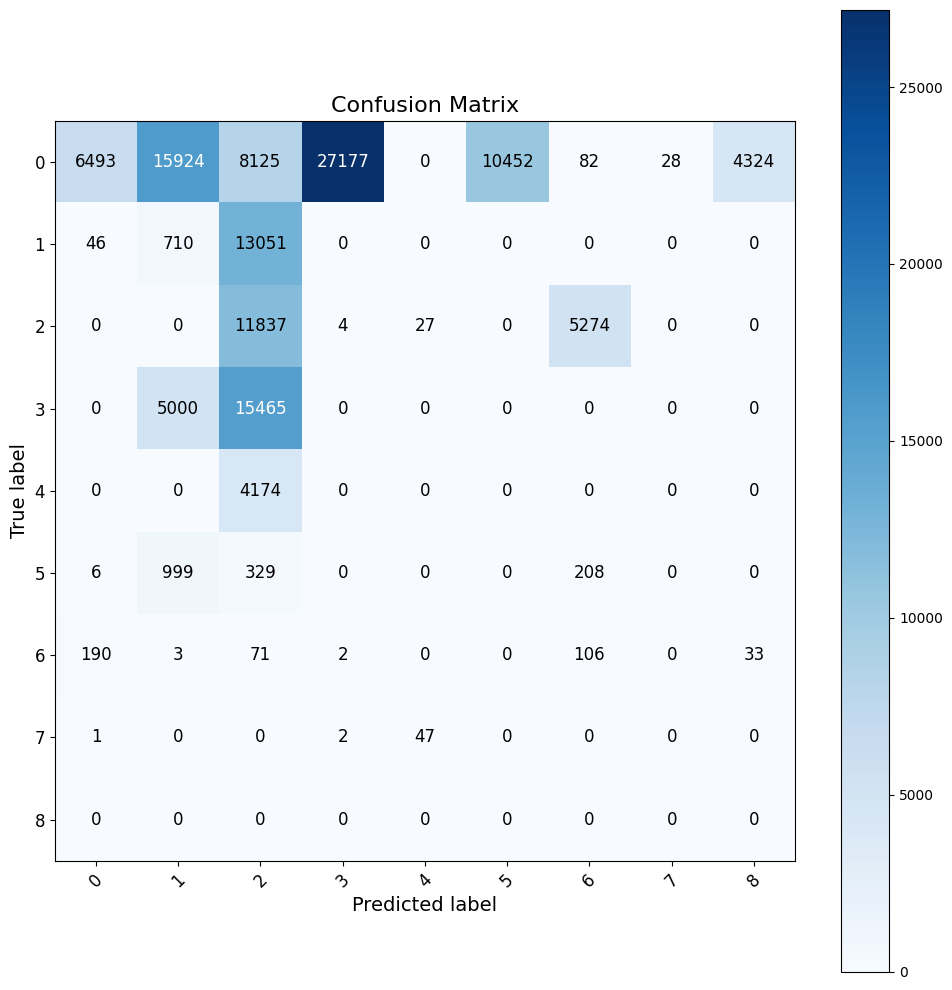

In [37]:
# %% [markdown]
# ## Model Evaluation
# Use the pre-trained k–means model to predict cluster labels and compute evaluation metrics.
# %% [code]
# Predict cluster labels


# Transform the test data using the loaded PCA model
X_pca_test = pca_clustering.transform(X_scaled)
print("Transformed test features shape:", X_pca_test.shape)

# %% [markdown]
# ## Model Evaluation
# Predict cluster labels using the loaded K–Means model (on PCA-transformed features).
predicted_clusters = kmeans_model.predict(X_pca_test)
print("Predicted cluster labels shape:", predicted_clusters.shape)

# Compute silhouette score on PCA-transformed test data.
sil_score = silhouette_score(X_pca_test, predicted_clusters)
print("Silhouette Score:", sil_score)

# If ground truth labels are available, compute confusion matrix and classification report.
if 'label' in data.columns:
    y_true = y  # Ground truth labels
    cm = confusion_matrix(y_true, predicted_clusters)
    print("\nConfusion Matrix:")
    print(cm)
    
    unique_classes = np.union1d(np.unique(y_true), np.unique(predicted_clusters))
    target_names_test = [str(cls) for cls in unique_classes]
    
    report = classification_report(
        y_true,
        predicted_clusters,
        labels=unique_classes,
        target_names=target_names_test,
        zero_division=0
    )
    print("\nClassification Report:")
    print(report)
else:
    print("No ground truth labels available; skipping confusion matrix and classification report.")

# %% [markdown]
# ### Plot Confusion Matrix (if ground truth is available)
if 'label' in data.columns:
    def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
        fig, ax = plt.subplots(figsize=(10, 10))
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        tick_marks = np.arange(len(classes))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes, rotation=45, fontsize=12)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes, fontsize=12)
        ax.set_xlabel("Predicted label", fontsize=14)
        ax.set_ylabel("True label", fontsize=14)
        ax.set_title(title, fontsize=16)
        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], "d"),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black",
                        fontsize=12)
        fig.tight_layout()
        return fig

    fig_cm = plot_confusion_matrix(cm, target_names_test)
    plt.show()
else:
    print("Skipping confusion matrix plot as no ground truth labels are available.")


In [38]:
# %% [markdown]
# ## Save Evaluation Outputs
# %% [code]
results_txt_path = os.path.join(output_folder, "evaluation_report.txt")
with open(results_txt_path, "w") as f:
    f.write("Evaluation Metrics\n")
    f.write("==================\n\n")
    f.write("Silhouette Score: {:.4f}\n\n".format(sil_score))
    if 'label' in data.columns:
        f.write("Classification Report:\n")
        f.write(report)
        f.write("\nConfusion Matrix:\n")
        f.write(np.array2string(cm, separator=", "))
print("Evaluation report saved to:", results_txt_path)

if 'label' in data.columns:
    cm_df = pd.DataFrame(cm, index=target_names_test, columns=target_names_test)
    cm_csv_path = os.path.join(output_folder, "confusion_matrix.csv")
    cm_df.to_csv(cm_csv_path, index=True)
    print("Confusion matrix saved as CSV:", cm_csv_path)

# (Optional) Save the silhouette score as a text file
sil_score_path = os.path.join(output_folder, "silhouette_score.txt")
with open(sil_score_path, "w") as f:
    f.write("Silhouette Score: {:.4f}\n".format(sil_score))
print("Silhouette score saved to:", sil_score_path)

Evaluation report saved to: outputs\2018\KMeans\kmeans_test_run_full\evaluation_report.txt
Confusion matrix saved as CSV: outputs\2018\KMeans\kmeans_test_run_full\confusion_matrix.csv
Silhouette score saved to: outputs\2018\KMeans\kmeans_test_run_full\silhouette_score.txt
